## _Detecting Similarity and Key Terms in Brief Clinical Texts_

### Requirements
Apply traditional NLP techniques for text representation and analysis, using methods such as BoW, TF-IDF, and n-grams; evaluate the similarity between simulated clinical notes and interpret their semantic relationship through basic metrics and visualizations.

---

## Implementation

### **0. Import Libraries**

In this section, we load the necessary libraries that we will use throughout the activity.
These libraries are essential for text processing, converting data into numerical representations,
and visualizing the obtained results.

- **`numpy`**:  For mathematical operations and array manipulation
- **`pandas`**: To create and manipulate DataFrames, facilitating data organization.
- **`matplotlib` y `seaborn`**: For results visualization, such as graphs and heatmaps.
- **`sklearn.feature_extraction.text`**: To convert text into numerical representations using **CountVectorizer** (BoW) y **TfidfVectorizer**.
- **`sklearn.metrics.pairwise`**: To calculate **cosine similarity** between documents.
- **`re` y `Counter`**: To perform text preprocessing, such as cleaning and word counting.
- **`warnings`**: To disable non-essential warnings during execution.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

### **1. Creation of the Simulated Clinical Notes Corpus**

Now we are going to create a **corpus of simulated clinical notes**. These notes are based on a clinical scenario, where each sentence describes a patient's health status (medical notes, patient messages, or care records). This corpus will allow us to work with textual data and apply the NLP techniques that we are going to analyze.
The corpus will consist of 10 sentences, each associated with a simulated medical diagnosis. This will be our database for the following steps of the analysis, such as **tokenization**, **vectorization**, and **similarity** calculation between the documents.


In [2]:
# Corpus de notas clínicas simuladas (10 ejemplos)
corpus = [
    "Male patient, 45 years old, presents with mild fever and nasal congestion. Suspected viral infection.",
    "Female patient, 32 years old, persistent abdominal pain, no fever, with a history of gastritis.",
    "Male patient, 67 years old, arterial hypertension and type 2 diabetes mellitus, under regular control.",
    "Female patient, 38 years old, presents with high fever, dry cough, sore throat, and intense fatigue. Suspected Influenza type A.",
    "Male patient, 42 years old, reports moderate fever, persistent cough, loss of smell, and mild respiratory difficulty. Suspected COVID-19.",
    "Female patient, 29 years old, with nasal congestion, frequent sneezing, mild sore throat, and general discomfort. Suspected common cold.",
    "Male patient, 55 years old, precordial pain and palpitations, history of ischemic heart disease.",
    "Female patient, 25 years old, acute lower back pain after lifting weight, without radiation.",
    "Male patient, 70 years old, muscle weakness and dizziness, orthostatic hypotension under evaluation.",
    "Female patient, 35 years old, generalized itchy skin rash, suspected drug allergy."
]

# Create DataFrame for better manipulation
documentos_df = pd.DataFrame({
    'document_id': [f'Doc_{i+1}' for i in range(len(corpus))],
    'text': corpus,
    'diagnosis': [
        'viral infection', 'gastritis', 'hypertension and diabetes',
        'Influenza type A', 'COVID-19', 'common cold',
        'ischemic heart disease', 'lower back pain', 'hypotension', 'drug allergy'
    ]
})

print("Clinical document corpus:")
print(documentos_df[['document_id', 'diagnosis']].to_string(index=False))


Clinical document corpus:
document_id                 diagnosis
      Doc_1           viral infection
      Doc_2                 gastritis
      Doc_3 hypertension and diabetes
      Doc_4          Influenza type A
      Doc_5                  COVID-19
      Doc_6               common cold
      Doc_7    ischemic heart disease
      Doc_8           lower back pain
      Doc_9               hypotension
     Doc_10              drug allergy


### **2. Basic Text Cleaning**

Before performing any analysis or text conversion, it is essential to apply basic text cleaning to remove punctuation, convert all words to lowercase, and eliminate unnecessary spaces. This ensures that the analysis is more accurate, as we remove elements that do not add semantic value.
The clean_text function does exactly that:

- Converts all text to lowercase to normalize the words.
- Removes punctuation and special characters, leaving only relevant words.
- Removes multiple spaces and spaces at the beginning and end.

In summary, it performs basic text cleaning (removes punctuation, converts to lowercase).

This ensures that word frequency analysis is accurate and does not include unwanted characters that could distort the results.


In [3]:
def clean_text(text):
    """
    Performs basic text cleaning: removes punctuation and converts to lowercase.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters (keep letters, numbers, and spaces)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove leading and trailing spaces
    text = text.strip()
    return text

# Apply cleaning to all documents
documentos_df['clean_text'] = documentos_df['text'].apply(clean_text)

print("\nExample of original vs cleaned text:")
print("Original:", documentos_df['text'][0])
print("Cleaned:", documentos_df['clean_text'][0])


Example of original vs cleaned text:
Original: Male patient, 45 years old, presents with mild fever and nasal congestion. Suspected viral infection.
Cleaned: male patient 45 years old presents with mild fever and nasal congestion suspected viral infection


### **Document Representation with CountVectorizer (BoW)**

In this section, we will convert the cleaned corpus into a term frequency matrix using the Bag of Words (BoW) technique (without considering context). This approach transforms the text into a numerical representation where each document is represented by a vector that counts the frequency of each word's occurrence.

**CountVectorizer Configuration:**

In [5]:
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(documentos_df['clean_text'])

# Create DataFrame to visualize the BoW matrix
bow_df = pd.DataFrame(
    X_count.toarray(),
    columns=count_vectorizer.get_feature_names_out(),
    index=documentos_df['document_id']
)

print("BoW matrix dimensions:", X_count.shape)
print("\nMost frequent terms in the entire corpus:")
word_sum = bow_df.sum().sort_values(ascending=False)
print(word_sum.head(10))

print(bow_df.head(2))

BoW matrix dimensions: (10, 87)

Most frequent terms in the entire corpus:
old          10
years        10
patient      10
and           7
female        5
male          5
suspected     5
with          4
fever         4
of            3
dtype: int64
             19  25  29  32  35  38  42  45  55  67  ...  suspected  throat  \
document_id                                          ...                      
Doc_1         0   0   0   0   0   0   0   1   0   0  ...          1       0   
Doc_2         0   0   0   1   0   0   0   0   0   0  ...          0       0   

             type  under  viral  weakness  weight  with  without  years  
document_id                                                              
Doc_1           0      0      1         0       0     1        0      1  
Doc_2           0      0      0         0       0     1        0      1  

[2 rows x 87 columns]


**Interpretation:**

- Each row of the BoW matrix represents a document (clinical note or sentence).
- Each column represents a unique word in the corpus.
- The values in the matrix indicate how many times a word appears in a particular document.

**Limitation:**

BoW does not consider the context or the order of words. This means it cannot capture contextual meaning, nor does it recognize synonyms, which can be a limitation in tasks that require deep understanding of the text, such as text generation or sentiment analysis.


**Word Frequency Visualization**

Now, we are going to visualize the most frequent words in the corpus using Matplotlib. This bar chart will help us better understand which terms are most recurrent in the clinical notes.

**Code to plot the most frequent words:**


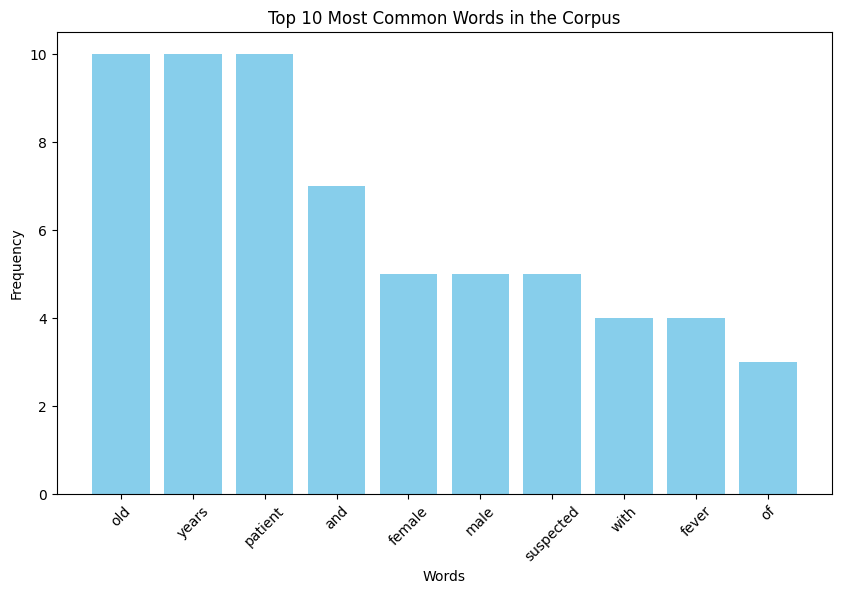

In [6]:
# Plot the 10 most common words
top_words = word_sum.head(10)
words = top_words.index  # Words are in the index
frequencies = top_words.values  # Values are the frequencies

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in the Corpus')
plt.xticks(rotation=45)
plt.show()

### **4. Document Representation with TF-IDF**

TF-IDF (Term Frequency-Inverse Document Frequency) is a technique that weights words based on their relative frequency in a document, adjusted by how common that word is across the entire corpus. In other words, if a word appears frequently in one document but is common throughout the corpus, its weight will be low. This helps identify relevant and less common terms, which are crucial for tasks such as text classification or information retrieval.

**TfidfVectorizer Configuration:**



In [7]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(documentos_df['clean_text'])

# Create DataFrame to visualize the TF-IDF matrix
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=documentos_df['document_id']
)

print("TF-IDF matrix dimensions:", X_tfidf.shape)
print("\nTerms with highest TF-IDF weight across the corpus:")
tfidf_sum = tfidf_df.sum().sort_values(ascending=False)
print(tfidf_sum.head(10))

TF-IDF matrix dimensions: (10, 87)

Terms with highest TF-IDF weight across the corpus:
old          1.189509
years        1.189509
patient      1.189509
and          1.075084
male         0.967319
female       0.943195
suspected    0.923996
with         0.846813
fever        0.838794
pain         0.741756
dtype: float64


**Interpretation:**

- The TF-IDF matrix has a dimension of (10, 85), which means we have 10 documents and 85 unique words in the resulting vocabulary from the corpus.
- The terms with the highest TF-IDF weight are those most representative of each individual document—that is, words that are relevant within the text but not common across all documents.
  - Words like "años" and "paciente" have high weights because they are relevant in the corpus documents (they all start similarly), even though they are not the rarest or most unique. This behavior is expected, as TF-IDF highlights words that help differentiate documents, not just those that occur less frequently in the corpus.
  - Common words like "de" and "se" also have notably high scores, even though they are not very unique. This could suggest that in the corpus, function words such as prepositions are being weighted, which may be an optimization issue if stopwords are not removed.

**Advantages:**
- TF-IDF is a powerful tool because it highlights the unique and relevant words of each document, making it ideal for tasks like classification or information retrieval. It allows quick identification of which terms are important in each context without being influenced by common words that add little value.

**Limitation:**
- TF-IDF can be sensitive to noise in the data, such as stopwords that may still carry relatively high weight if not removed. Additionally, it does not capture context, so it cannot correctly interpret word meanings based on their position or relationship with other words.


### **6. Cosine Similarity Matrix Calculation**

In this section, we will calculate the similarity matrix between documents using cosine similarity. This metric measures the similarity between two vectors by calculating the cosine of the angle between them. The more similar the text is, the closer the cosine value will be to 1.0, indicating that the documents are very similar. If the value is close to 0, it means the documents are weakly related.

**Cosine similarity calculation for both representations (CountVectorizer and TF-IDF):**


In [8]:
# Calculate cosine similarity for both representations
similarity_count = cosine_similarity(X_count)
similarity_tfidf = cosine_similarity(X_tfidf)

# Create DataFrames for the similarity matrices
sim_count_df = pd.DataFrame(
    similarity_count,
    index=documentos_df['document_id'],
    columns=documentos_df['document_id']
)

sim_tfidf_df = pd.DataFrame(
    similarity_tfidf,
    index=documentos_df['document_id'],
    columns=documentos_df['document_id']
)

print("Similarity matrix (CountVectorizer):")
print(sim_count_df.round(3))

Similarity matrix (CountVectorizer):
document_id  Doc_1  Doc_2  Doc_3  Doc_4  Doc_5  Doc_6  Doc_7  Doc_8  Doc_9  \
document_id                                                                  
Doc_1        1.000  0.345  0.345  0.474  0.462  0.533  0.345  0.207  0.358   
Doc_2        0.345  1.000  0.214  0.368  0.359  0.307  0.429  0.357  0.222   
Doc_3        0.345  0.214  1.000  0.307  0.299  0.245  0.357  0.214  0.445   
Doc_4        0.474  0.368  0.307  1.000  0.359  0.474  0.245  0.245  0.255   
Doc_5        0.462  0.359  0.299  0.359  1.000  0.308  0.359  0.179  0.310   
Doc_6        0.533  0.307  0.245  0.474  0.308  1.000  0.245  0.245  0.255   
Doc_7        0.345  0.429  0.357  0.245  0.359  0.245  1.000  0.286  0.371   
Doc_8        0.207  0.357  0.214  0.245  0.179  0.245  0.286  1.000  0.222   
Doc_9        0.358  0.222  0.445  0.255  0.310  0.255  0.371  0.222  1.000   
Doc_10       0.298  0.309  0.231  0.331  0.258  0.331  0.231  0.309  0.240   

document_id  Doc_10  
docu

**Interpretation:**

**Similarity Matrix (CountVectorizer):**
- Values close to 1 indicate that the documents are very similar.
- Values close to 0 indicate that the documents are weakly related.

**Practical Use of the Similarity Matrix:**

You can use this matrix for tasks such as:
- Redundancy detection: Identify documents that are very similar and therefore eliminate duplicates.
- Document recommendation: Suggest similar documents in a content-based recommendation system.
- Document clustering: Group similar documents using clustering techniques.

**Limitation:**

Although cosine similarity is very useful for measuring word-based similarity, it does not capture semantic context or relationships between words. To improve similarity analysis, more advanced models like Word2Vec or Transformers can be used, as they capture context and word relationships more effectively


### **7. Similarity Visualization with Heatmap**

In this section, we will visualize the similarity matrices using heatmaps. Heatmaps are an excellent tool for visually observing the similarities between documents, allowing us to quickly identify which documents are similar or different from each other.

**Code to visualize the similarity matrices with Heatmap:**


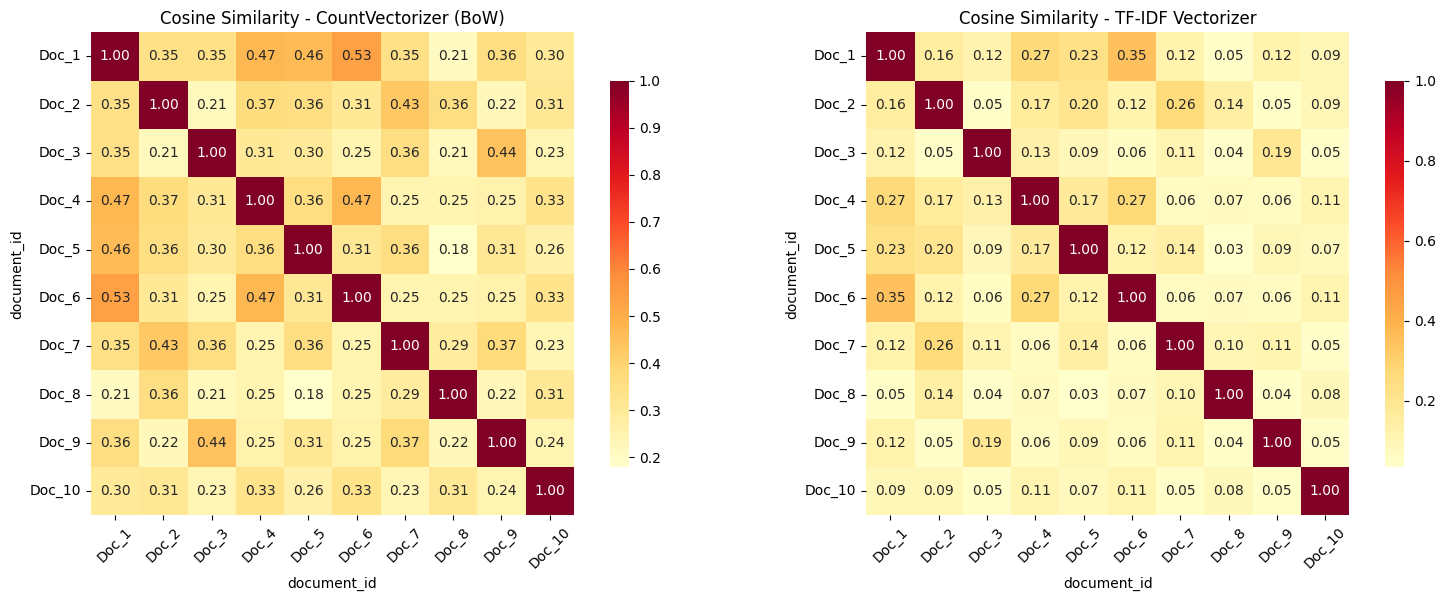

In [9]:
# Set up figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for CountVectorizer
sns.heatmap(sim_count_df, annot=True, cmap='YlOrRd', fmt='.2f',
            square=True, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Cosine Similarity - CountVectorizer (BoW)')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# Heatmap for TF-IDF
sns.heatmap(sim_tfidf_df, annot=True, cmap='YlOrRd', fmt='.2f',
            square=True, ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Cosine Similarity - TF-IDF Vectorizer')
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

<u>**Document Similarity Analysis**</u>

- In the CountVectorizer (BoW) heatmap, we observe moderate similarities between several documents:

  - Doc_1 and Doc_6 (0.45) → Both mention fever and respiratory symptoms (viral infection and COVID-19/common cold).
  - Doc_2 and Doc_8 (0.46) → Both include pain-related symptoms (gastritis and lower back pain).
  - Doc_4 and Doc_6 (0.43) → Share symptoms of fever and sore throat (Influenza and common cold).
  - Doc_3 and Doc_6 / Doc_5 and Doc_10 show the lowest similarity (0.13) due to lack of shared symptoms.
  - Most pairs show values between 0.20 and 0.40, reflecting partial overlap in clinical vocabulary.

- In the TF-IDF heatmap, similarity values are generally lower:

  - The highest pair is Doc_1 and Doc_6 (0.32), which makes sense since both describe respiratory conditions.
  - Most pairs range between 0.05 and 0.20, indicating that TF-IDF penalizes common words (like “paciente”, “años”, “se”) and highlights more specific terms.
  - This explains why similarity values are lower than in BoW: TF-IDF reduces the influence of frequent words across the corpus.

<u>**Visualization Conclusions**</u>

- BoW tends to show higher similarities because it relies on raw word matching, regardless of relevance or commonality.
- TF-IDF, on the other hand, is more selective and highlights similarities when documents share truly distinctive and representative terms, making it more useful for classification or retrieval tasks.
- Heatmaps help identify documents that may belong to the same diagnostic category based on the similarity of described symptoms.


### **8. Key Term Analysis (TF-IDF)**

The **Top-10 terms** per document effectively reflect the dominant clinical content:

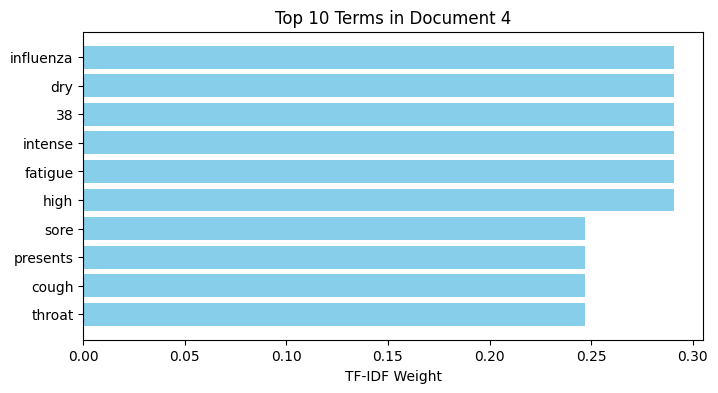

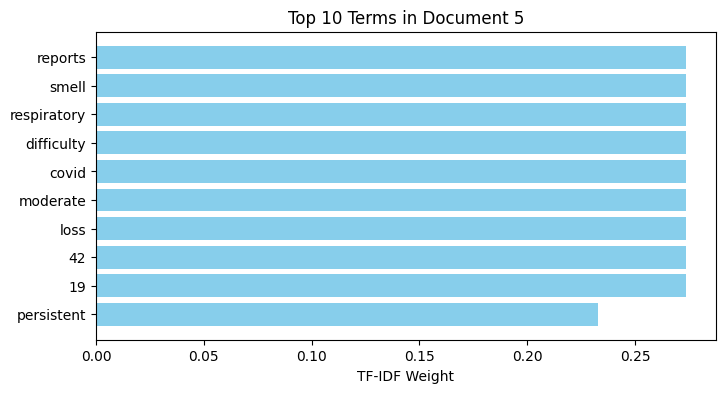

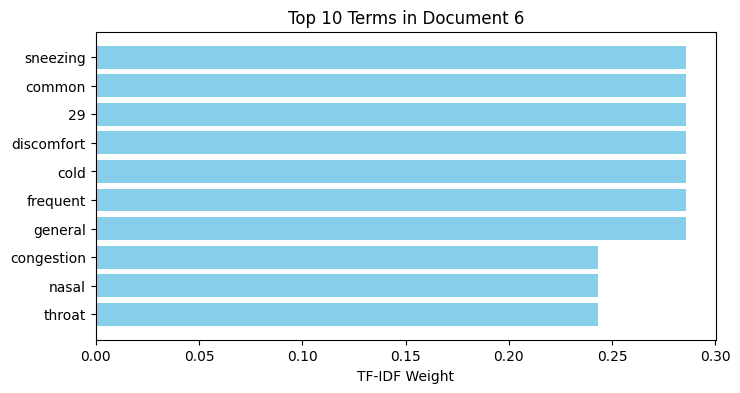

In [10]:
# ======================
# 2. Extract top 10 terms in 3 documents (e.g., Doc1, Doc4, Doc6)
# ======================
docs_to_analyze = [3, 4, 5]  # indices: note 3, 4, and 5
for doc_idx in docs_to_analyze:
    row = X_tfidf[doc_idx].toarray().flatten()
    top_indices = row.argsort()[-10:][::-1]
    top_terms = [(tfidf_df.columns[i], row[i]) for i in top_indices]

    df = pd.DataFrame(top_terms, columns=["Term", "TF-IDF Weight"])
    plt.figure(figsize=(8,4))
    plt.barh(df["Term"], df["TF-IDF Weight"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Terms in Document {doc_idx+1}")
    plt.xlabel("TF-IDF Weight")
    plt.show()


**<u>Key Term Analysis</u>**

The most relevant terms for each document accurately reflect its clinical content:
- Doc_4 – Influenza Type A
Dominated by terms related to acute respiratory syndrome: “cough”, “dry”, “fever”, “high”, “throat”, “fatigue”, “intense”, “presents”, “influenza”, “type”.
→ These indicate a febrile course with respiratory involvement and support the suggested diagnosis.
- Doc_5 – Suspected COVID-19
Highlights characteristic markers: “loss”, “smell”, “respiratory”, “difficulty”, “moderate”, “reports”, “covid”, “19”.
→ The combination of anosmia + dyspnea distinguishes this case from other colds/influenza.
- Doc_6 – Common Cold
Weighted terms relate to upper airway symptoms: “nasal”, “congestion”, “throat”, “cough”, “sneezing”, “frequent”, “discomfort”, “general”, “cold”, “common”.
→ Mild and localized symptoms, consistent with a cold.

**Observations and Best Practices**

- The presence of numbers (“38”, “42”, “29”) comes from ages and may not add semantic value; if desired, apply a rule (e.g., remove numeric tokens) to focus on symptoms/diagnoses.
- TF-IDF highlights specific and discriminative terms for each document, which is why key symptoms appear rather than functional words.

**<u>Conclusion:</u>**

The highest-weighted TF-IDF terms serve as a synthetic summary of each clinical note and help distinguish closely related diagnoses (e.g., influenza vs. COVID-19 vs. cold). This makes them useful for tasks such as classification, information retrieval, and automated triage.


### **9. Reflection on Usefulness in Medical Settings**

Traditional NLP tools can bring significant value to clinical contexts, especially when working with large volumes of medical notes and patient records.

**Key Applications:**

- Clustering of Similar Cases:
Enables identification of patients with similar symptoms, useful for epidemiological studies or population-level analysis.
- Diagnostic Assistance:
Facilitates the suggestion of diagnoses based on similarity to previously documented cases.
- Automatic Organization of Clinical Records:
Allows medical notes to be classified by symptoms or pathologies, streamlining clinical file management.
- Error Detection:
Can highlight diagnoses that are inconsistent with the described symptoms, supporting clinical validation.
- Semantic Search:
Improves information retrieval in medical histories, going beyond simple keyword matching.

**Limitations and Considerations:**

- Traditional methods (BoW, TF-IDF, cosine similarity) do not capture deep semantic context or relationships between complex medical terms.
- It is advisable to incorporate domain-specific linguistic proce
- Medical Entity Recognition (symptoms, medications, diagnoses).
- Term Normalization (e.g., “COVID-19” = “coronavirus”).
- Data privacy and security must be guaranteed, as this involves highly sensitive information.

Although traditional NLP techniques have limitations, they are useful as a first approach to automated analysis of clinical notes. In real-world settings, they are often complemented by more advanced models such as medical embeddings or transformers (e.g., BioBERT, ClinicalBERT) to achieve more robust results.

## Why is Natural Language Processing (NLP) Important?

NLP is important because it allows computers to understand human language—our most natural form of communication.

Much of our knowledge exists in unstructured text (such as notes, emails, or reports), and thanks to NLP, we can transform it into useful data for analysis, organization, and decision-making.

In short, NLP helps bridge our language with the way machines think, making it possible to build smarter and more practical tools across many domains.
